# Cloud Detection with OmniCloudMask

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/cloud_detection.ipynb)

This notebook demonstrates how to use OmniCloudMask integration in GeoAI for detecting clouds and cloud shadows in satellite imagery. OmniCloudMask performs semantic segmentation to classify pixels into four categories:

- **0: Clear** - Cloud-free pixels
- **1: Thick Cloud** - Opaque cloud cover
- **2: Thin Cloud** - Semi-transparent cloud cover
- **3: Cloud Shadow** - Shadows cast by clouds

OmniCloudMask supports Sentinel-2, Landsat 8, PlanetScope, and Maxar imagery at 10-50m spatial resolution.

## Installation

Uncomment the following line to install the required packages if needed.

In [ ]:
 %pip install -U "geoai-py[extra]"

## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.transform import from_bounds
import tempfile
import os

# Import GeoAI cloud mask utilities
# Import from the tools subpackage
from geoai.tools.cloudmask import (
    predict_cloud_mask,
    predict_cloud_mask_from_raster,
    predict_cloud_mask_batch,
    calculate_cloud_statistics,
    create_cloud_free_mask,
    CLEAR,
    THICK_CLOUD,
    THIN_CLOUD,
    CLOUD_SHADOW,
)

## 1. Create Synthetic Satellite Imagery

For demonstration purposes, let's create synthetic satellite imagery with RGB and NIR bands.

In [4]:
def create_synthetic_satellite_image(size=(512, 512), cloud_coverage=0.3):
    """
    Create synthetic satellite imagery (R, G, NIR bands).

    Args:
        size: Image dimensions (height, width)
        cloud_coverage: Fraction of image covered by clouds (0-1)

    Returns:
        3D array with shape (3, height, width) containing R, G, NIR bands
    """
    np.random.seed(42)

    # Create base reflectance values typical of vegetation
    # Red: low (absorbed by chlorophyll)
    # Green: medium
    # NIR: high (reflected by vegetation)
    red = np.random.rand(*size) * 2000 + 500  # 500-2500
    green = np.random.rand(*size) * 3000 + 1000  # 1000-4000
    nir = np.random.rand(*size) * 5000 + 3000  # 3000-8000

    # Add some spatial structure (vegetation patches)
    from scipy.ndimage import gaussian_filter

    red = gaussian_filter(red, sigma=20)
    green = gaussian_filter(green, sigma=20)
    nir = gaussian_filter(nir, sigma=20)

    # Add cloud patterns
    if cloud_coverage > 0:
        # Create cloud mask
        cloud_base = np.random.rand(*size)
        cloud_base = gaussian_filter(cloud_base, sigma=30)
        cloud_mask = cloud_base > (1 - cloud_coverage)

        # Clouds have high reflectance in all bands
        cloud_value = 8000
        red[cloud_mask] = cloud_value + np.random.rand(cloud_mask.sum()) * 1000
        green[cloud_mask] = cloud_value + np.random.rand(cloud_mask.sum()) * 1000
        nir[cloud_mask] = cloud_value + np.random.rand(cloud_mask.sum()) * 1000

    # Stack into (3, H, W) format
    image = np.stack([red, green, nir], axis=0).astype(np.float32)

    return image


# Create synthetic image
image = create_synthetic_satellite_image(size=(512, 512), cloud_coverage=0.2)
print(f"Created synthetic image with shape: {image.shape}")
print(f"Value range: {image.min():.0f} - {image.max():.0f}")

Created synthetic image with shape: (3, 512, 512)
Value range: 1470 - 5593


## 2. Visualize the Input Image

Let's visualize the RGB composite of our synthetic satellite image.

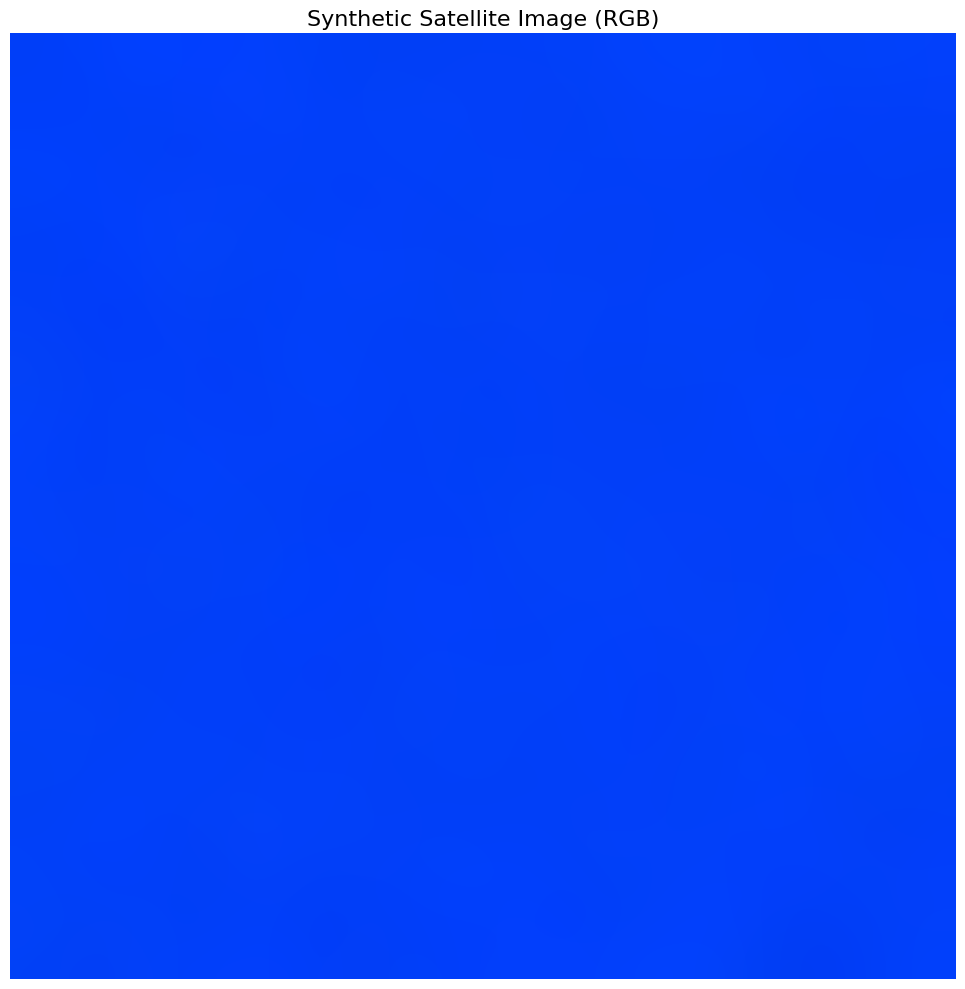

In [5]:
def visualize_rgb(image, title="RGB Composite"):
    """
    Visualize RGB composite from satellite image.

    Args:
        image: Array with shape (3, H, W) or (H, W, 3)
        title: Plot title
    """
    # Convert to (H, W, 3) if needed
    if image.shape[0] == 3:
        rgb = image[:3].transpose(1, 2, 0)  # Take R, G, (NIR->B for vis)
    else:
        rgb = image[:, :, :3]

    # Normalize to 0-1 for display
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_norm)
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_rgb(image, "Synthetic Satellite Image (RGB)")

## 3. Predict Cloud Mask

Now let's use OmniCloudMask to detect clouds and cloud shadows.

In [6]:
# Predict cloud mask
# Note: First run will download the model (may take a moment)
cloud_mask = predict_cloud_mask(
    image,
    batch_size=1,
    inference_device="cpu",  # Use "cuda" if GPU available
    inference_dtype="fp32",  # Use "bf16" for faster inference on supported hardware
    patch_size=1000,
    model_version=3,  # Model versions: 1, 2, or 3
)

print(f"Cloud mask shape: {cloud_mask.shape}")
print(f"Classes found: {np.unique(cloud_mask)}")

PM_model_OCM_7.43_R_G_NIR_regnety_004.py(…):   0%|          | 0.00/72.3M [00:00<?, ?B/s]

PM_model_OCM_7.43_R_G_NIR_edgenext_small(…):   0%|          | 0.00/37.2M [00:00<?, ?B/s]

Cloud mask shape: (512, 512)
Classes found: [1 3]


## 4. Visualize Cloud Mask

Let's visualize the cloud detection results with a color-coded map.

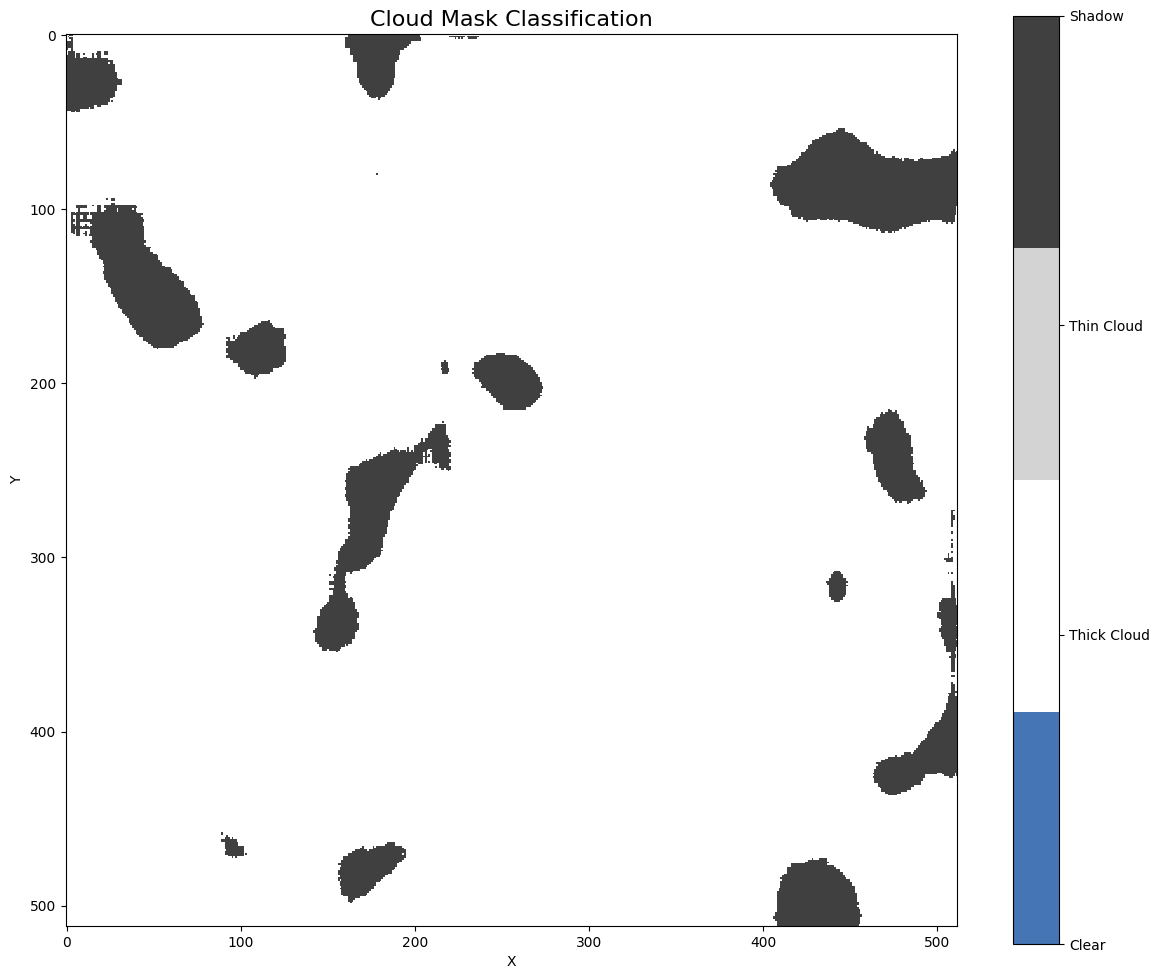

In [7]:
# Create colormap for cloud classes
# Clear (blue), Thick Cloud (white), Thin Cloud (light gray), Shadow (dark gray)
colors = ["#4575b4", "#ffffff", "#d3d3d3", "#404040"]
cmap = ListedColormap(colors)

plt.figure(figsize=(12, 10))
im = plt.imshow(cloud_mask, cmap=cmap, interpolation="nearest", vmin=0, vmax=3)
plt.title("Cloud Mask Classification", fontsize=16)
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(["Clear", "Thick Cloud", "Thin Cloud", "Shadow"])
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

## 5. Calculate Cloud Statistics

Let's quantify the cloud coverage and other statistics.

In [8]:
stats = calculate_cloud_statistics(cloud_mask)

print("Cloud Coverage Statistics:")
print(f"  Total pixels: {stats['total_pixels']:,}")
print(f"  Clear pixels: {stats['clear_pixels']:,} ({stats['clear_percent']:.1f}%)")
print(f"  Thick cloud: {stats['thick_cloud_pixels']:,}")
print(f"  Thin cloud: {stats['thin_cloud_pixels']:,}")
print(f"  Cloud shadow: {stats['shadow_pixels']:,}")
print(f"  \nTotal cloud coverage: {stats['cloud_percent']:.1f}%")
print(f"  Shadow coverage: {stats['shadow_percent']:.1f}%")

Cloud Coverage Statistics:
  Total pixels: 262,144
  Clear pixels: 0 (0.0%)
  Thick cloud: 243,019
  Thin cloud: 0
  Cloud shadow: 19,125
  
Total cloud coverage: 92.7%
  Shadow coverage: 7.3%


## 6. Create Cloud-Free Mask

Create a binary mask showing which pixels are usable (cloud-free).

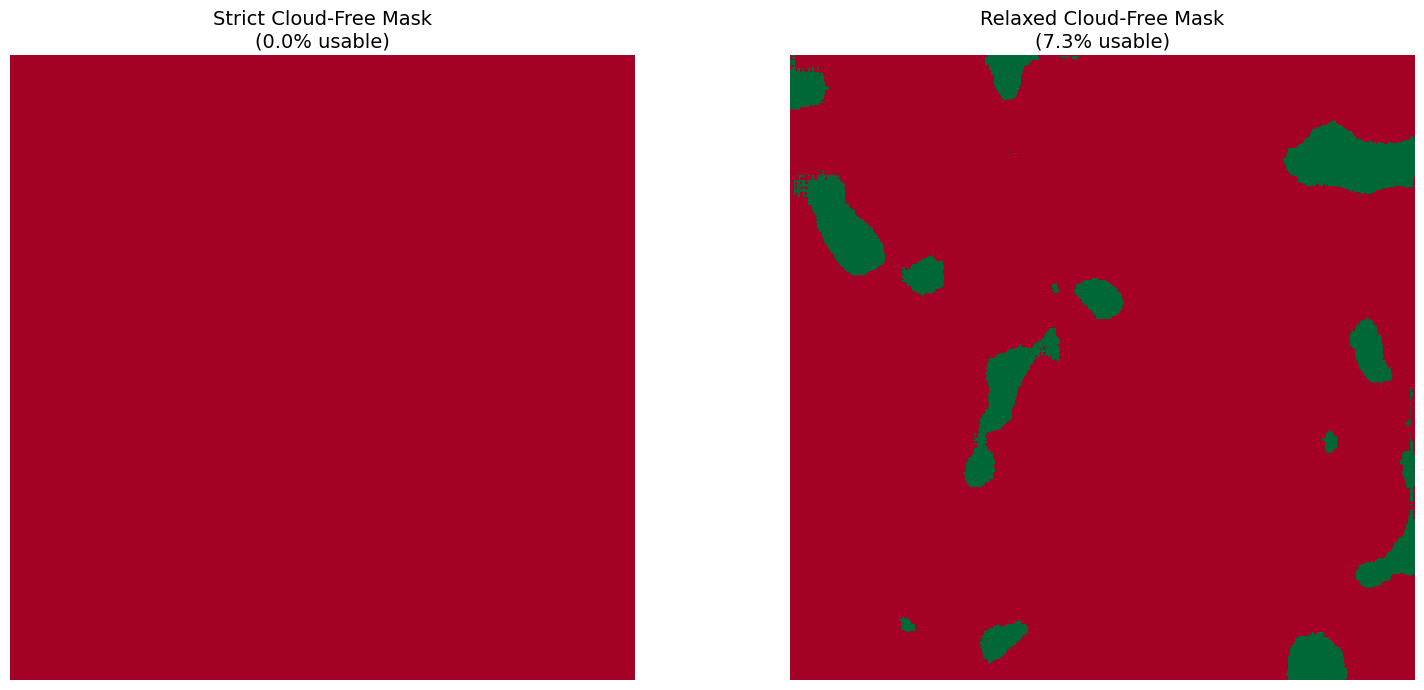

In [9]:
# Strict cloud-free mask (only clear pixels)
cloud_free_strict = create_cloud_free_mask(
    cloud_mask, include_thin_clouds=False, include_shadows=False
)

# Relaxed cloud-free mask (accept thin clouds and shadows)
cloud_free_relaxed = create_cloud_free_mask(
    cloud_mask, include_thin_clouds=True, include_shadows=True
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(cloud_free_strict, cmap="RdYlGn", interpolation="nearest")
axes[0].set_title(
    f"Strict Cloud-Free Mask\n({cloud_free_strict.sum() / cloud_free_strict.size * 100:.1f}% usable)",
    fontsize=14,
)
axes[0].axis("off")

axes[1].imshow(cloud_free_relaxed, cmap="RdYlGn", interpolation="nearest")
axes[1].set_title(
    f"Relaxed Cloud-Free Mask\n({cloud_free_relaxed.sum() / cloud_free_relaxed.size * 100:.1f}% usable)",
    fontsize=14,
)
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 7. Compare Different Classes

Let's visualize each cloud class separately.

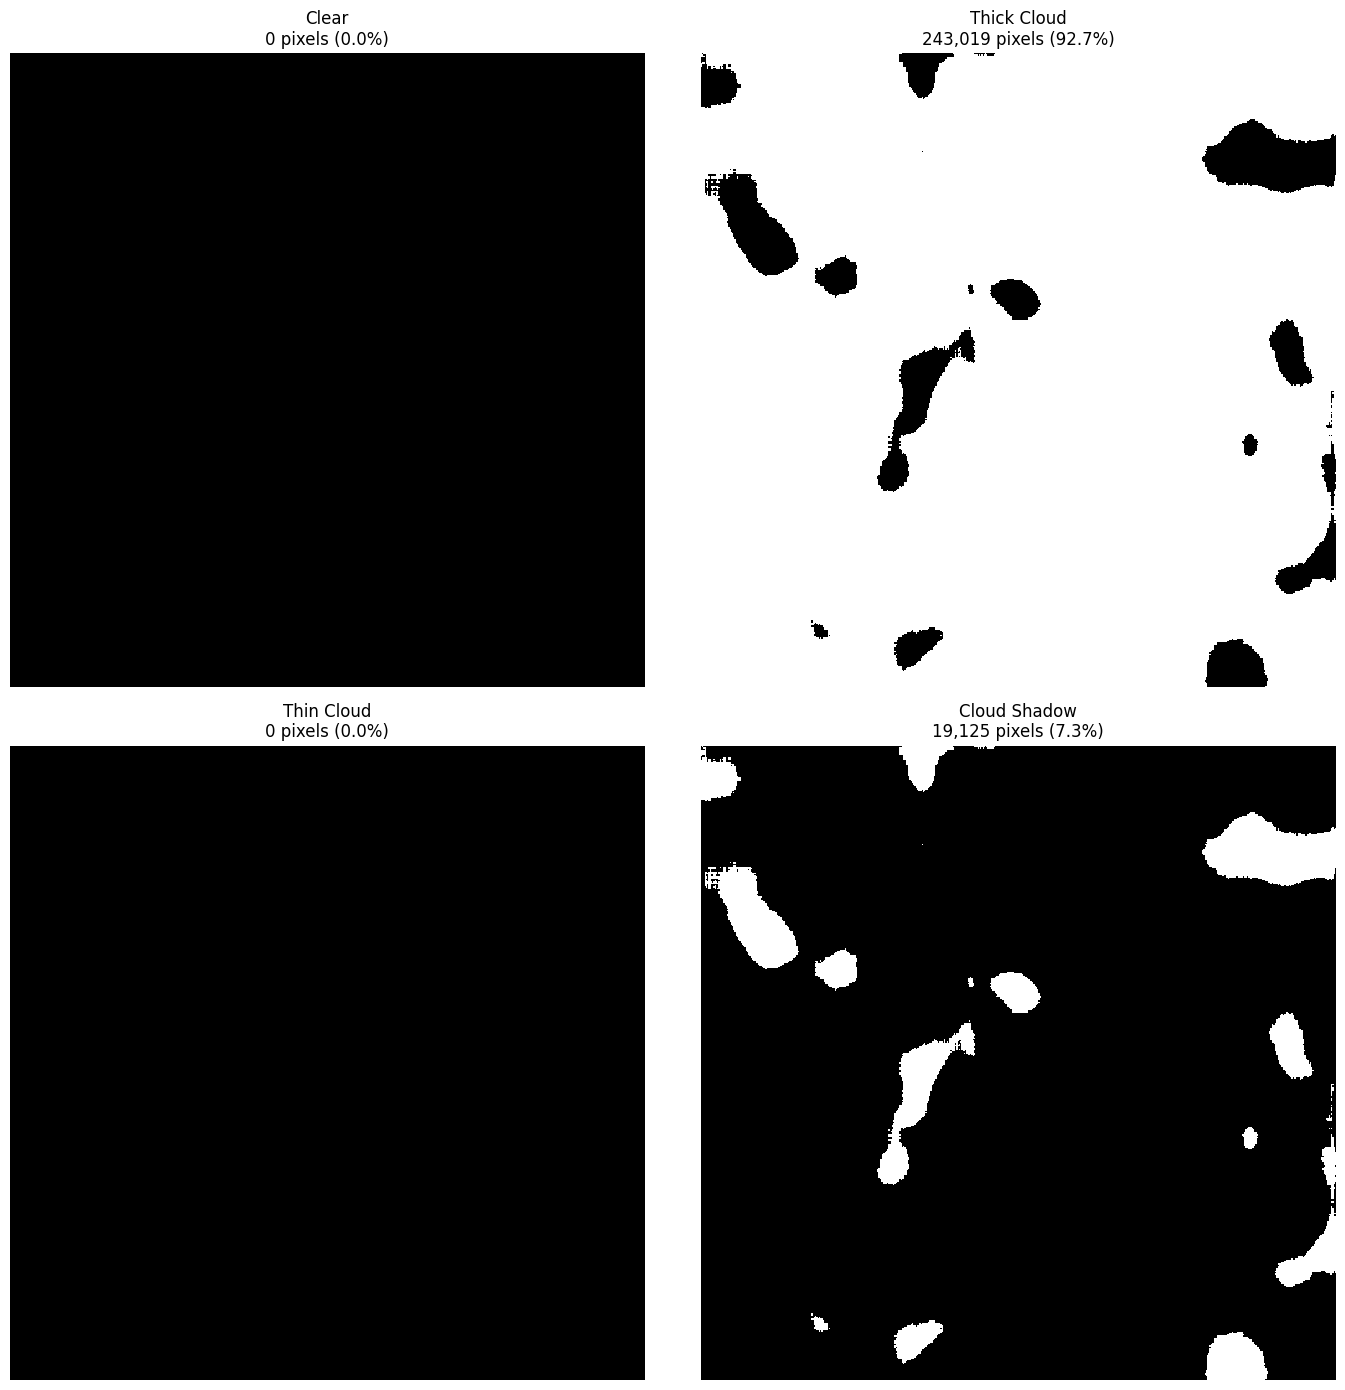

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

class_names = ["Clear", "Thick Cloud", "Thin Cloud", "Cloud Shadow"]
class_values = [CLEAR, THICK_CLOUD, THIN_CLOUD, CLOUD_SHADOW]

for i, (name, value) in enumerate(zip(class_names, class_values)):
    # Create binary mask for this class
    class_mask = (cloud_mask == value).astype(np.uint8)
    count = class_mask.sum()
    percent = count / class_mask.size * 100

    axes[i].imshow(class_mask, cmap="gray", interpolation="nearest")
    axes[i].set_title(f"{name}\n{count:,} pixels ({percent:.1f}%)", fontsize=12)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 8. Working with GeoTIFF Files

OmniCloudMask can process GeoTIFF files directly while preserving geospatial metadata.

In [11]:
# Create temporary directory
tmpdir = tempfile.mkdtemp()
print(f"Working directory: {tmpdir}")

# Save synthetic image as GeoTIFF
input_tif = os.path.join(tmpdir, "satellite_image.tif")
output_tif = os.path.join(tmpdir, "cloud_mask.tif")

# Create geographic transform
transform = from_bounds(
    west=-120.0,
    south=35.0,
    east=-119.0,
    north=36.0,
    width=image.shape[2],
    height=image.shape[1],
)

# Write image to GeoTIFF (3 bands: R, G, NIR)
with rasterio.open(
    input_tif,
    "w",
    driver="GTiff",
    height=image.shape[1],
    width=image.shape[2],
    count=3,
    dtype=image.dtype,
    crs="EPSG:4326",
    transform=transform,
    compress="lzw",
) as dst:
    for i in range(3):
        dst.write(image[i], i + 1)

print(f"Saved satellite image to: {input_tif}")

Working directory: /tmp/tmpn6put1ox
Saved satellite image to: /tmp/tmpn6put1ox/satellite_image.tif


In [12]:
# Predict cloud mask from GeoTIFF
predict_cloud_mask_from_raster(
    input_path=input_tif,
    output_path=output_tif,
    red_band=1,  # Band indices for R, G, NIR
    green_band=2,
    nir_band=3,
    inference_device="cpu",
)

print(f"Cloud mask saved to: {output_tif}")

Cloud mask saved to: /tmp/tmpn6put1ox/cloud_mask.tif


In [13]:
# Verify output and metadata preservation
with rasterio.open(input_tif) as src_in:
    print("Input metadata:")
    print(f"  CRS: {src_in.crs}")
    print(f"  Transform: {src_in.transform}")
    print(f"  Bounds: {src_in.bounds}")
    print(f"  Bands: {src_in.count}")

print()

with rasterio.open(output_tif) as src_out:
    print("Output metadata:")
    print(f"  CRS: {src_out.crs}")
    print(f"  Transform: {src_out.transform}")
    print(f"  Bounds: {src_out.bounds}")
    print(f"  Bands: {src_out.count}")

    # Read and verify cloud mask
    mask_from_file = src_out.read(1)
    print(f"  Classes: {np.unique(mask_from_file)}")

print("\n✓ Geospatial metadata preserved!")

Input metadata:
  CRS: EPSG:4326
  Transform: | 0.00, 0.00,-120.00|
| 0.00,-0.00, 36.00|
| 0.00, 0.00, 1.00|
  Bounds: BoundingBox(left=-120.0, bottom=35.0, right=-119.0, top=36.0)
  Bands: 3

Output metadata:
  CRS: EPSG:4326
  Transform: | 0.00, 0.00,-120.00|
| 0.00,-0.00, 36.00|
| 0.00, 0.00, 1.00|
  Bounds: BoundingBox(left=-120.0, bottom=35.0, right=-119.0, top=36.0)
  Bands: 1
  Classes: [1 3]

✓ Geospatial metadata preserved!


## 9. Batch Processing Multiple Images

Process multiple satellite images at once using batch processing.

In [14]:
# Create multiple test images with different cloud coverage
input_files = []
cloud_coverages = [0.1, 0.3, 0.5]

for i, coverage in enumerate(cloud_coverages):
    # Create image with specific cloud coverage
    test_image = create_synthetic_satellite_image(
        size=(256, 256), cloud_coverage=coverage
    )

    # Save to file
    filepath = os.path.join(tmpdir, f"scene_{i}_clouds{int(coverage*100)}.tif")

    transform = from_bounds(-120, 35, -119, 36, 256, 256)
    with rasterio.open(
        filepath,
        "w",
        driver="GTiff",
        height=256,
        width=256,
        count=3,
        dtype=test_image.dtype,
        crs="EPSG:4326",
        transform=transform,
    ) as dst:
        for j in range(3):
            dst.write(test_image[j], j + 1)

    input_files.append(filepath)

print(f"Created {len(input_files)} test images")
for f in input_files:
    print(f"  - {os.path.basename(f)}")

Created 3 test images
  - scene_0_clouds10.tif
  - scene_1_clouds30.tif
  - scene_2_clouds50.tif


In [15]:
# Batch process all images
output_dir = os.path.join(tmpdir, "cloud_masks")

output_files = predict_cloud_mask_batch(
    input_paths=input_files,
    output_dir=output_dir,
    red_band=1,
    green_band=2,
    nir_band=3,
    inference_device="cpu",
    suffix="_cloudmask",
    verbose=True,
)

print(f"\nProcessed {len(output_files)} images")

Processing 1/3: /tmp/tmpn6put1ox/scene_0_clouds10.tif
  ✓ Saved to: /tmp/tmpn6put1ox/cloud_masks/scene_0_clouds10_cloudmask.tif
Processing 2/3: /tmp/tmpn6put1ox/scene_1_clouds30.tif
  ✓ Saved to: /tmp/tmpn6put1ox/cloud_masks/scene_1_clouds30_cloudmask.tif
Processing 3/3: /tmp/tmpn6put1ox/scene_2_clouds50.tif
  ✓ Saved to: /tmp/tmpn6put1ox/cloud_masks/scene_2_clouds50_cloudmask.tif

Processed 3 images


In [16]:
# Analyze results from batch processing
print("\nCloud Coverage Analysis:")
print("-" * 60)

for output_file in output_files:
    with rasterio.open(output_file) as src:
        mask = src.read(1)

    stats = calculate_cloud_statistics(mask)

    filename = os.path.basename(output_file)
    print(f"\n{filename}:")
    print(f"  Clear: {stats['clear_percent']:.1f}%")
    print(f"  Cloud: {stats['cloud_percent']:.1f}%")
    print(f"  Shadow: {stats['shadow_percent']:.1f}%")


Cloud Coverage Analysis:
------------------------------------------------------------

scene_0_clouds10_cloudmask.tif:
  Clear: 0.1%
  Cloud: 78.0%
  Shadow: 21.9%

scene_1_clouds30_cloudmask.tif:
  Clear: 0.1%
  Cloud: 78.0%
  Shadow: 21.9%

scene_2_clouds50_cloudmask.tif:
  Clear: 100.0%
  Cloud: 0.0%
  Shadow: 0.0%


## 10. Use Case: Filter Usable Scenes

A common workflow is to filter satellite scenes based on cloud coverage threshold.

## 11. Best Practices and Tips

### Input Requirements

- **Bands**: Requires Red, Green, and NIR bands
- **Resolution**: Optimized for 10-50m spatial resolution
- **Sensors**: Validated on Sentinel-2, Landsat 8, PlanetScope, Maxar
- **Values**: Works with reflectance (0-1) or digital numbers

### Performance Tips

- Use **inference_dtype='bf16'** for 2-3x speedup on supported hardware
- Use **inference_device='cuda'** if GPU available
- Adjust **patch_size** based on available memory
- Use **batch_size > 1** for faster batch processing

### Model Versions

- **v3.0** (default): Expanded training dataset for higher accuracy.
- **v2.0**: A smaller faster model ensemble with improved robustness.
- **v1.0**: Baseline model release supporting the OmniCloudMask paper.

### When to Use OmniCloudMask

✓ Pre-processing satellite imagery for analysis  
✓ Filtering scenes based on cloud coverage  
✓ Creating cloud-free composites  
✓ Quality assessment of satellite data  
✓ Time series analysis (exclude cloudy observations)  

### Sensor-Specific Band Indices

**Sentinel-2:**
```python
red_band=4, green_band=3, nir_band=8
```

**Landsat 8/9:**
```python
red_band=4, green_band=3, nir_band=5
```

**PlanetScope:**
```python
red_band=3, green_band=2, nir_band=4
```

## Summary

In this notebook, we demonstrated:

1. ✅ Predicting cloud masks from numpy arrays
2. ✅ Visualizing cloud detection results
3. ✅ Calculating cloud coverage statistics
4. ✅ Creating cloud-free masks
5. ✅ Processing GeoTIFF files while preserving metadata
6. ✅ Batch processing multiple scenes
7. ✅ Filtering scenes based on cloud coverage

OmniCloudMask is a powerful tool for cloud detection in satellite imagery, essential for many remote sensing workflows.

## References

- [OmniCloudMask GitHub Repository](https://github.com/DPIRD-DMA/OmniCloudMask)
- [GeoAI Documentation](https://opengeoai.org)

In [ ]:
# Cleanup temporary files
import shutil

shutil.rmtree(tmpdir)
print("Cleaned up temporary files")